# Minimising the Rosenbrock function

In this notebook we'll be finding the minimum of the rosenbrock function using `jax`. The idea is to practice doing some linear algebra and gradient stuff.

In [1]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import grad, jit, vmap, pmap, make_jaxpr

In [2]:
X = jnp.arange(-10, 10, 0.5)
Y = jnp.arange(-10, 10, 0.5)
X, Y = jnp.meshgrid(X, Y)

@jit # We can jit compile the function to make it run faster
def rosenbrock_function(X,Y,a=1,b=100):
    return (a-X)**2 + b*(Y-X**2)**2

Z = rosenbrock_function(X, Y)

In [3]:
# Show the jaxpr for the rosenbrock function
make_jaxpr(rosenbrock_function)(1.,1.)

{ lambda ; a:f32[] b:f32[]. let
    c:f32[] = xla_call[
      call_jaxpr={ lambda ; d:f32[] e:f32[]. let
          f:f32[] = sub 1.0 d
          g:f32[] = integer_pow[y=2] f
          h:f32[] = integer_pow[y=2] d
          i:f32[] = sub e h
          j:f32[] = integer_pow[y=2] i
          k:f32[] = mul j 100.0
          l:f32[] = add g k
        in (l,) }
      name=rosenbrock_function
    ] a b
  in (c,) }

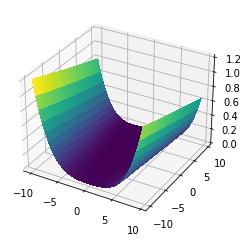

In [4]:
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap='viridis',
                       linewidth=0, antialiased=False)

In [5]:
# Calculate gradients
df_dxy = grad(rosenbrock_function, argnums=(0, 1))
df_dx  = grad(rosenbrock_function, argnums=0)
df_dy  = grad(rosenbrock_function, argnums=1)

In [7]:
# Show df_dx and df_dy
x = jnp.arange(-10, 10, 0.5)
y = jnp.arange(-10, 10, 0.5)

vmap(df_dx)(x,y), vmap(df_dy)(x,y)

(DeviceArray([-4.40022e+05, -3.79071e+05, -3.24020e+05, -2.74569e+05,
              -2.30418e+05, -1.91267e+05, -1.56816e+05, -1.26765e+05,
              -1.00814e+05, -7.86630e+04, -6.00120e+04, -4.45610e+04,
              -3.20100e+04, -2.20590e+04, -1.44080e+04, -8.75700e+03,
              -4.80600e+03, -2.25500e+03, -8.04000e+02, -1.53000e+02,
              -2.00000e+00, -5.10000e+01, -0.00000e+00,  4.51000e+02,
               1.60200e+03,  3.75300e+03,  7.20400e+03,  1.22550e+04,
               1.92060e+04,  2.83570e+04,  4.00080e+04,  5.44590e+04,
               7.20100e+04,  9.29610e+04,  1.17612e+05,  1.46263e+05,
               1.79214e+05,  2.16765e+05,  2.59216e+05,  3.06867e+05],            dtype=float32),
 DeviceArray([-22000., -19950., -18000., -16150., -14400., -12750.,
              -11200.,  -9750.,  -8400.,  -7150.,  -6000.,  -4950.,
               -4000.,  -3150.,  -2400.,  -1750.,  -1200.,   -750.,
                -400.,   -150.,      0.,     50.,      0.,   -150.,


### Plot the partial derivatives

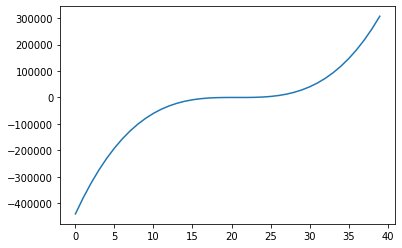

In [8]:
plt.plot(vmap(df_dx)(x,y))

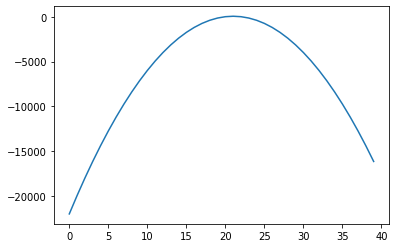

In [9]:
plt.plot(vmap(df_dy)(x,y))

Note that the output of `df_dxy` is the same as `df_dx` and `df_dy` calculated separately. One can probably assume that `df_dxy` is somehow more efficiently calculated than the former pair.

In [10]:
# Show df_dxy
vmap(df_dxy)(x, y)

(DeviceArray([-4.40022e+05, -3.79071e+05, -3.24020e+05, -2.74569e+05,
              -2.30418e+05, -1.91267e+05, -1.56816e+05, -1.26765e+05,
              -1.00814e+05, -7.86630e+04, -6.00120e+04, -4.45610e+04,
              -3.20100e+04, -2.20590e+04, -1.44080e+04, -8.75700e+03,
              -4.80600e+03, -2.25500e+03, -8.04000e+02, -1.53000e+02,
              -2.00000e+00, -5.10000e+01, -0.00000e+00,  4.51000e+02,
               1.60200e+03,  3.75300e+03,  7.20400e+03,  1.22550e+04,
               1.92060e+04,  2.83570e+04,  4.00080e+04,  5.44590e+04,
               7.20100e+04,  9.29610e+04,  1.17612e+05,  1.46263e+05,
               1.79214e+05,  2.16765e+05,  2.59216e+05,  3.06867e+05],            dtype=float32),
 DeviceArray([-22000., -19950., -18000., -16150., -14400., -12750.,
              -11200.,  -9750.,  -8400.,  -7150.,  -6000.,  -4950.,
               -4000.,  -3150.,  -2400.,  -1750.,  -1200.,   -750.,
                -400.,   -150.,      0.,     50.,      0.,   -150.,


### Numeric differentiation

To double check that autodiff works correctly

In [11]:
def finite_differences(f, x, y):
    eps = 1e-3
    # f(0+e, 1, 2) - f(0-e, 1, 2) / 2e
    df_dx = jnp.array([(f(x + eps, y) - f(x - eps, y)) / (2 * eps)])
    df_dy = jnp.array([(f(x, y + eps) - f(x, y - eps)) / (2 * eps)])
    return df_dx, df_dy

fdf_dx, fdf_dy = finite_differences(rosenbrock_function, x, y)

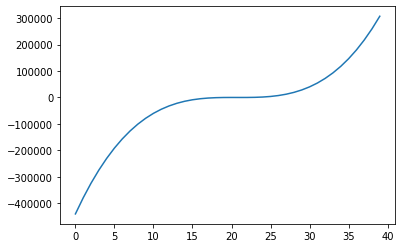

In [12]:
plt.plot(fdf_dx.T)

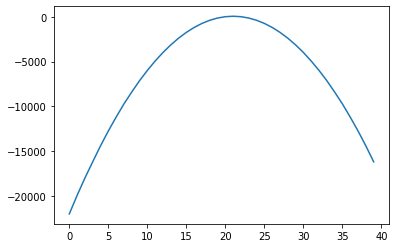

In [13]:
plt.plot(fdf_dy.T)

### Hessians and Jacobians

In [14]:
from jax import jacfwd, jacrev

def hessian(f):
    return jit(jacfwd(jacrev(rosenbrock_function, argnums=(0, 1)), argnums =(0, 1)))

J = jacrev(rosenbrock_function, argnums=(0, 1))(1., 1.)
H = hessian(rosenbrock_function)(1., 1.)

print(f'Jacobian:\n{J}')
print()
print(f'Full Hessian:\n{H}')

Jacobian:
(DeviceArray(-0., dtype=float32, weak_type=True), DeviceArray(0., dtype=float32, weak_type=True))

Full Hessian:
((DeviceArray(802., dtype=float32, weak_type=True), DeviceArray(-400., dtype=float32, weak_type=True)), (DeviceArray(-400., dtype=float32, weak_type=True), DeviceArray(200., dtype=float32, weak_type=True)))


As you can see, at (1,1) the jacobian is (0,0). Furthermore, the Hessian is symmetric and has these eigenvalues:

In [15]:
# Calculate the eigen-decomposition of the Hessian matrix
np.linalg.eig(H)

(array([1.00160065e+03, 3.99360776e-01], dtype=float32),
 array([[ 0.8947843 ,  0.44649878],
        [-0.44649878,  0.8947843 ]], dtype=float32))

The eigenvalues are positive, therefore there is a minimum at (1,1).

### Calculating the minimum using SGD

Next we want to calculate the minimum value using Stochastic Gradient Descent (SGD). For something like the Rosenbrock function, this should be inefficient and so there will be room for improvement after we're done.

In [16]:
import jax

@jit  # notice how we do jit only at the highest level - XLA will have plenty of space to optimize
def update(x, y, lr = 0.001):
    
    df_dx, df_dy = grad(rosenbrock_function, argnums=(0, 1))(x,y)

    # SGD update
    return x - lr * df_dx, y - lr * df_dy

In [17]:
%%time
x = np.random.normal()
y = np.random.normal()

num_epochs = 20000
for _ in range(num_epochs):
    x, y = update(x, y)

CPU times: user 587 ms, sys: 256 ms, total: 843 ms
Wall time: 539 ms


In [18]:
x, y

(DeviceArray(0.99989897, dtype=float32, weak_type=True),
 DeviceArray(0.9997976, dtype=float32, weak_type=True))

It worked!